In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC  
from sklearn import metrics
from xgboost import XGBClassifier
import random
import itertools
import warnings
warnings.filterwarnings('ignore')

In [508]:
df = pd.read_csv('google_books.csv')
tfidf_one_hot_words = pd.read_csv('tfidf_one_hot_words.csv')
print(df.shape)

(1116, 14)


In [509]:
df.dropna(subset=['description'], inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(1111, 14)


,title,subtitle,authors,publisher,month,year,categories,pageCount,listPrice,images,isEbook,ratingsCount,averageRating,description
0,The Litigators,NaN,John Grisham,Dell,10,2011,Fiction,496,9.99,False,True,137,3.5,The partners at Finley & Figg often ...
1,Ragtime,A Novel,E.L. Doctorow,Random House,11,2010,Fiction,336,14.99,True,True,57,3.5,Selected by the Modern Library as on...
2,Her Perfect Man,NaN,Mary Lynn Baxter,Silhouette,5,2011,Fiction,192,3.99,False,True,1,5.0,One look at firebrand Katherine Mays...
3,The Vanished Man,A Lincoln Rhyme Novel,Jeffery Deaver,Simon and Schuster,8,2012,Fiction,577,NaN,False,False,19,4.0,Hunting down a killer and master ill...
4,One Sunday,A Novel,Carrie Gerlach Cecil,Simon and Schuster,2,2013,Fiction,255,NaN,False,False,6,4.0,When her unborn child's health is pu...


## Feature Engineering

In [510]:
## target feature indicating if book gets a 4.5 rating or above
def above4p5(x):
    if x >= 4.5:
        return 1
    else:
        return 0

df['above4p5'] = df['averageRating'].map(lambda x: above4p5(x))

In [511]:
## make feature that indicates if popular or unpopular author 
## i.e. does the author appear more than once 
author_count = df.authors.value_counts() 
popular_authors = list(author_count[author_count >= 3].index)

def popular_author(x):
    if x in popular_authors:
        return 1
    else:
        return 0

df['popular_author'] = df['authors'].map(lambda x: popular_author(x))
print(df['popular_author'].sum())

21


In [512]:
words = tfidf_one_hot_words.iloc[:,0:49]

df = pd.concat([ pd.get_dummies(df['publisher']), pd.get_dummies(df['month']), 
                     pd.get_dummies(df['year']), pd.get_dummies(df['categories']), 
                df['images'], df['isEbook'], df['popular_author'], df['above4p5']], axis=1)
df = pd.concat([df, words], join="inner", axis=1)
df.head()

,A&C Black,A&amp;C Black,Abrams,Academic Press,Acculant Publishing,Ace,Addison-Wesley,Addison-Wesley Professional,Adelphi Edizioni spa,African Books Collective,...,year,guide,readers,recipes,man,novel,students,just,real,design
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Solving imbalances in the train test split due to uneven distribution of infrequent words

In [513]:
## this cell makes a train-test-split based on dataframe index
## it is taking random samples of words (column) and splitting it into a mini
## train-test dataframe then merging to a running tally of random samples
## once the running tally reaches approximately 75% of the main dataframe,
## the loop halts
freq_words = words.apply(np.sum, axis=0)

## initialze empty dataframes
train = pd.DataFrame(columns = df.columns)
test = pd.DataFrame(columns = df.columns)

## while loop until train dataframe reaches 75% of main df n_rows
while train.shape[0] <= round(len(df.index) * 0.75):
    ## sample a word and split in to train/test based on the word
    samp = freq_words[freq_words<100].sample(1).index[0]
    col = tfidf_one_hot_words[[samp]]

    ## gets all the rows where that word occurs
    col = col[col[samp]==1]

    ## estimate of how many rows we want in micro train dataset
    n_train = round(len(col.index) * 0.75)

    ## get a sample of the indices that go in to the micro train dataset
    inds = random.sample(range(0,len(col.index)), k=n_train)
    train_inds = [list(col.index)[ind] for ind in inds]

    ## takes difference between train indices and micro dataframe indices to get test in  dices
    test_inds = list(set(list(col.index))- set(train_inds))

    ## join the micro indices with the macro indices, which we will continue to add to
    train = pd.concat([train, df.iloc[train_inds]])
    test = pd.concat([test, df.iloc[test_inds]])

In [514]:
print(train.shape)
train.head()

(856, 465)


,A&C Black,A&amp;C Black,Abrams,Academic Press,Acculant Publishing,Ace,Addison-Wesley,Addison-Wesley Professional,Adelphi Edizioni spa,African Books Collective,...,year,guide,readers,recipes,man,novel,students,just,real,design
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
143,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
277,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [515]:
## manually making the train-test-split
X_train = train.drop(['above4p5'], axis=1)
y_train = train[['above4p5']]

X_test = test.drop(['above4p5'], axis=1)
y_test = test[['above4p5']]

In [516]:
## solving errors that indicated some values were being passed as strings
X_train = X_train.astype(int)
X_test = X_test.astype(int)
                     
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [517]:
## making subsets without word vectors to compare model performance

X_train_sub = X_train.iloc[:,:-49]
X_test_sub = X_test.iloc[:,:-49]

In [518]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(856, 464) (856, 1) (288, 464) (288, 1)


## Baseline

Percentage of books with rating of 4.5 or above: 
 39.69% 

Percentage of books with rating below 4.5: 
 60.31% 

Can our model beat this baseline?


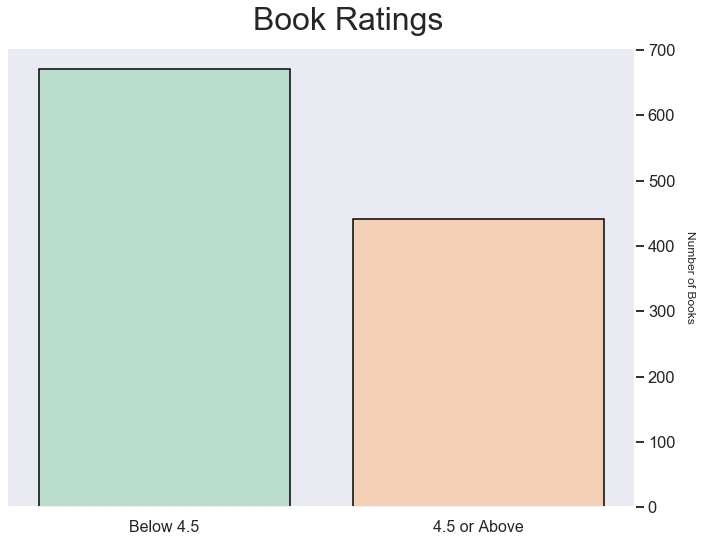

In [519]:
sns.set(style='dark', context='talk')
palette = sns.color_palette("Pastel2")

f, ax = plt.subplots(figsize=(10,8))
f.suptitle('Book Ratings', ha='center', fontsize=32)
ax = sns.countplot(df['above4p5'], data=df, palette=palette, edgecolor='black')
ax.set_xlabel('')
ax.set_xticklabels(['Below 4.5', '4.5 or Above'], fontsize=16)
ax.set_ylabel('Number of Books', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()
f.tight_layout(rect=[0, 0.03, 1, 0.95])

percent_above_4p5 = (df['above4p5'].sum()/df.shape[0])
print(f'Percentage of books with rating of 4.5 or above: \n {round(percent_above_4p5 * 100, 2)}% \n')
print(f'Percentage of books with rating below 4.5: \n {100 - round(percent_above_4p5 * 100, 2)}% \n')
print(f'Can our model beat this baseline?')

## Logistic Regression

In [110]:
## logistic regression without word vectors

clf = LogisticRegression(random_state=0).fit(X_train_sub, y_train)
print(f'Predicted values: \n {clf.predict(X_train_sub)} \n')
print(f'Probability predctions: \n {clf.predict_proba(X_train_sub)} \n')
print(f'Train score: \n {clf.score(X_train_sub, y_train)} \n')
print(f'Test score: \n {clf.score(X_test_sub, y_test)}')

Predicted values: 
 [1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0
 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1
 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0
 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0
 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 

In [116]:
## logistic regression with word vectors
## logistic regression performance worsens with word vectors
## logistic regression is bad for this task

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f'Predicted values: \n {clf.predict(X_train)} \n')
print(f'Probability predctions: \n {clf.predict_proba(X_train)} \n')
print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Predicted values: 
 [1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1
 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1
 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0
 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0
 1 1 

## Decision Trees

##### Random Forest

In [138]:
## random forest without word vectors

rf = RandomForestClassifier()
rf.fit(X_train_sub, y_train)

print(f'Predicted values: \n {rf.predict(X_train_sub)} \n')
print(f'Probability predctions: \n {rf.predict_proba(X_train_sub)} \n')
print(f'Train score: \n {rf.score(X_train_sub, y_train)} \n')
print(f'Test score: \n {rf.score(X_test_sub, y_test)}')

Predicted values: 
 [1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0
 1 1 

In [145]:
## random forest with word vectors
## rf model improves with word vectors
## but not as much as the other models

rf_words = RandomForestClassifier()
rf_words.fit(X_train, y_train)

print(f'Predicted values: \n {rf_words.predict(X_train)} \n')
print(f'Probability predctions: \n {rf_words.predict_proba(X_train)} \n')
print(f'Train score: \n {rf_words.score(X_train, y_train)} \n')
print(f'Test score: \n {rf_words.score(X_test, y_test)}')

Predicted values: 
 [1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1
 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0
 1 1 

In [149]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train_sub.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
isEbook,0.039480
images,0.026730
Random House,0.026231
Cooking,0.026049
2016,0.024208
5,0.023371
2009,0.022049
Computing,0.020441
2019,0.019726
7,0.018693


In [128]:
## Using random forest with grid search

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_random_forest.fit(X_train, y_train)

print(f'Parameters: \n {grid_random_forest.best_params_} \n')
print(f'Train score: \n {grid_random_forest.best_score_} \n')
print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

Parameters: 
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2} 

Train score: 
 0.8466898954703833 

Test score: 
 0.9103448275862069


##### AdaBoost

In [129]:
## AdaBoost without word vectors
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Train score: 
 0.8536585365853658 

Test score: 
 0.7379310344827587


##### Gradient Boost

In [132]:
## Gradient Boost without word vectors

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train_sub, y_train)

gbt_clf_train_preds = gbt_clf.predict(X_train_sub)
gbt_clf_test_preds = gbt_clf.predict(X_test_sub)

def display_acc_and_f1_score(true, preds):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Train scores:")
display_acc_and_f1_score(y_train, gbt_clf_train_preds)
print("\nTest scores:")
display_acc_and_f1_score(y_test, gbt_clf_test_preds)

Train scores:
Accuracy: 0.8583042973286876
F1-Score: 0.8451776649746193

Test scores:
Accuracy: 0.7758620689655172
F1-Score: 0.7670250896057348


In [133]:
## Gradient Boost with word vectors
## word vectors significantly improve Gradient Boost

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)

gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

def display_acc_and_f1_score(true, preds):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Train scores:")
display_acc_and_f1_score(y_train, gbt_clf_train_preds)
print("\nTest scores:")
display_acc_and_f1_score(y_test, gbt_clf_test_preds)


Train scores:
Accuracy: 0.9152148664343787
F1-Score: 0.9077117572692794

Test scores:
Accuracy: 0.8379310344827586
F1-Score: 0.8252788104089219


##### XGBoost

In [134]:
## XGB without word vectors

clf = XGBClassifier()

clf.fit(X_train_sub, y_train)

training_preds = clf.predict(X_train_sub)
test_preds = clf.predict(X_test_sub)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Train Score: \n {training_accuracy} \n')
print(f'Test score: \n {test_accuracy}')

Train Score: 
 0.7770034843205574 

Test score: 
 0.7310344827586207


In [135]:
## XGB with word vectors
## word vectors significantly improve XGB

clf = XGBClassifier()

clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Train Score: \n {training_accuracy} \n')
print(f'Test score: \n {test_accuracy}')

Train Score: 
 0.8803716608594657 

Test score: 
 0.8137931034482758


## Support Vector Machine

In [152]:
## svm without words

svclassifier = SVC(kernel='rbf', C=1000)  
svclassifier.fit(X_train_sub, y_train) 

y_pred = svclassifier.predict(X_test_sub)

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " " + str(accuracy_score(y_test, y_pred)))

[[124  22]
 [ 27 117]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       146
           1       0.84      0.81      0.83       144

    accuracy                           0.83       290
   macro avg       0.83      0.83      0.83       290
weighted avg       0.83      0.83      0.83       290

The accuracy score is 0.8310344827586207


In [398]:
## svm with words
## model performance improves with words

svclassifier = SVC(kernel='rbf', C=1000)  
svclassifier.fit(X_train, y_train) 

y_train_pred = svclassifier.predict(X_train)
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print(f'The train accuracy score is: {accuracy_score(y_train, y_train_pred)}')
print("The test accuracy score is" + " " + str(accuracy_score(y_test, y_pred)))

[[142   4]
 [ 21 123]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       146
           1       0.97      0.85      0.91       144

    accuracy                           0.91       290
   macro avg       0.92      0.91      0.91       290
weighted avg       0.92      0.91      0.91       290

The train accuracy score is: 0.991869918699187
The test accuracy score is 0.9137931034482759


## Naive Bayes

In [151]:
## NB wasn't good for the task, it had the lowest score of all the models

nb = BernoulliNB()
nb.fit(X_train, y_train)

print(f'Train score: \n {nb.score(X_train, y_train)} \n')
print(f'Test score: \n {nb.score(X_test, y_test)}')

Train score: 
 0.7409988385598142 

Test score: 
 0.6586206896551724


## Best Model Evaluation

In [ ]:
## Evaluate the random forest, print the diagram and shit 

##### How important were the word vectors to the random forest model?

In [203]:
## feature importances without words
rf_feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train_sub.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
rf_feature_importances.head(20)

,importance
isEbook,0.039480
images,0.026730
Random House,0.026231
Cooking,0.026049
2016,0.024208
5,0.023371
2009,0.022049
Computing,0.020441
2019,0.019726
7,0.018693


In [216]:
## feature importances with words

rf_words_feature_importances = pd.DataFrame(rf_words.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
rf_words_feature_importances.head(20)

,importance
times,0.017753
author,0.017682
images,0.017340
isEbook,0.017103
world,0.016756
life,0.016441
work,0.016164
edition,0.015804
design,0.015627
book,0.015332


In [221]:
rf_words_feature_importances.reset_index(inplace=True)
rf_words_feature_importances['index']

0                         times
1                        author
2                        images
3                       isEbook
4                         world
                 ...           
459    Harvest House Publishers
460        Sarah Crichton Books
461             Scholastic Inc.
462    Harvard University Press
463                       Orbit
Name: index, Length: 464, dtype: object

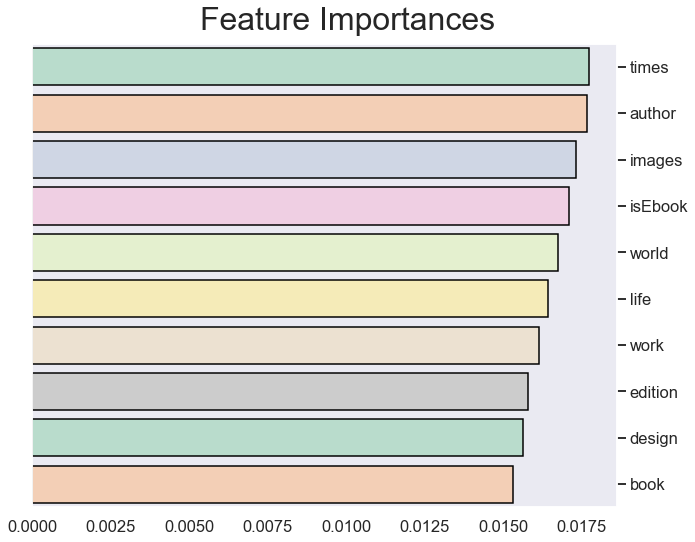

In [266]:
f, ax = plt.subplots(figsize=(10,8))
f.suptitle('Feature Importances', ha='center', fontsize=32)
ax = sns.barplot(rf_words_feature_importances['importance'][:10], rf_words_feature_importances['index'][:10],
                 palette=palette, edgecolor='black', orient="h")
ax.set_xlabel('')
ax.set_ylabel('', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()
f.tight_layout(rect=[0, 0.03, 1, 0.95])


In [222]:
y_pred_class = rf_words.predict(X_test)
cm = confusion_matrix(y_test,y_pred_class)
classes = ['Below 4.5', '4.5 or above']

In [506]:
y_test

,above4p5
611,1
772,0
1060,1
1062,0
198,0
...,...
563,1
21,1
853,1
598,1


[[143   3]
 [  9 135]]


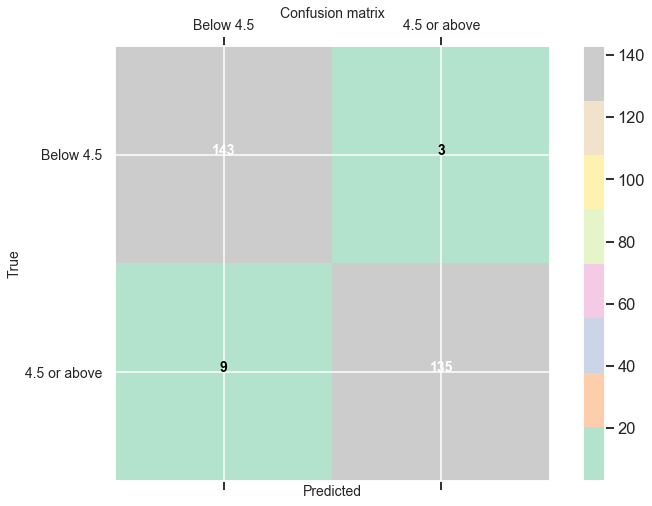

In [345]:
cm = confusion_matrix(y_test,y_pred_class)
classes = ['Below 4.5','4.5 or above']
print(cm)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Pastel2)
plt.title('Confusion matrix',fontdict={'size':14})
fig.colorbar(cax)
sns.axes_style({'text.color': 'red'})
ax.set_xticklabels([''] + classes,fontdict={'size':14})
ax.set_yticklabels([''] + classes,fontdict={'size':14})
plt.xlabel('Predicted',fontdict={'size':14})
plt.ylabel('True',fontdict={'size':14})
plt.grid(b=None)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="white" if cm[i, j] > thresh else "black")
plt.show()

In [301]:
# print the first 25 true and predicted responses
flatten = lambda l: [item for sublist in l for item in sublist]

print('True:', np.array((flatten(y_test.values[0:25]))))
print('Pred:', y_pred_class[0:25])

True: [1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1]
Pred: [1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1]


In [354]:
print(f'Precision: \n {metrics.precision_score(y_test, y_pred_class)} \n')
print(f'Recall: \n {metrics.recall_score(y_test, y_pred_class)} \n')
print(f'F1-Score: \n {metrics.f1_score(y_test, y_pred_class)}')

Precision: 
 0.9782608695652174 

Recall: 
 0.9375 

F1-Score: 
 0.9574468085106383


In [406]:
df_scores = pd.DataFrame(np.array([[0.818815331010453, 0.7448275862068966], 
                                   [0.9988385598141696, 0.9586206896551724], 
                                   [0.8536585365853658, 0.7379310344827587], 
                                   [0.9152148664343787, 0.8379310344827586], 
                                   [0.7770034843205574, 0.7310344827586207], 
                                   [0.991869918699187, 0.9137931034482759], 
                                   [0.7409988385598142, 0.6586206896551724]]), 
                        index=['Logistic Regression', 'Random Forest', 'AdaBoost', 'Gradient Boost',
                                'XGBoost', 'Support Vector Machine', 'Naive Bayes'], 
                         columns=['Train', 'Test'], )
# df.style.set_properties(**{'width': '300px'})


In [408]:
df_scores

,Train,Test
Logistic Regression,0.818815,0.744828
Random Forest,0.998839,0.958621
AdaBoost,0.853659,0.737931
Gradient Boost,0.915215,0.837931
XGBoost,0.777003,0.731034
Support Vector Machine,0.991870,0.913793
Naive Bayes,0.740999,0.658621


AUC: 0.9584760273972602


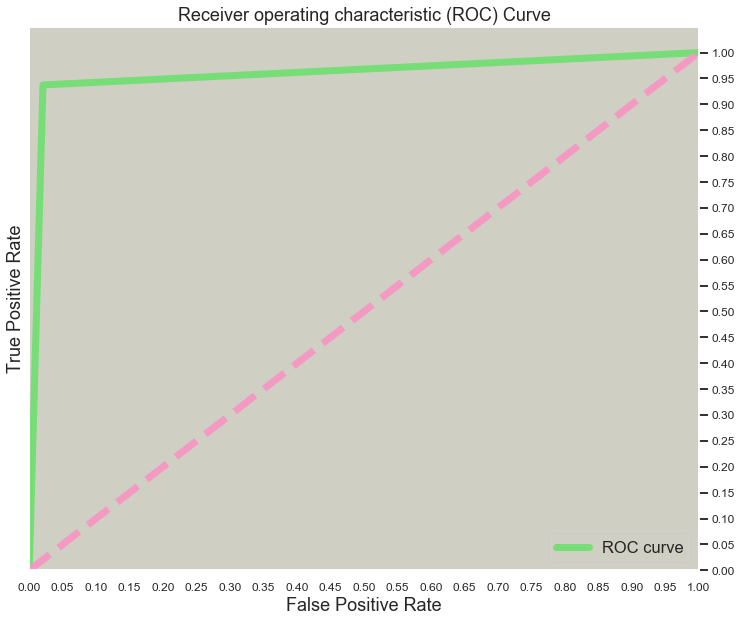

In [504]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("dark", {"axes.facecolor": "#cfcfc4"})
    print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    plt.figure(figsize=(12,10))
    lw = 2
    plt.plot(fpr, tpr, color='#77dd77',
         lw='7', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='#f49ac2', lw='7', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)], fontsize=12)
    plt.xticks([i/20.0 for i in range(21)], fontsize=12)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tick_params(axis='y', which='both', right='off', labelleft=False, labelright=True, labelsize=12)
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
#ROC/AUC
#First calculate the probability scores of each of the datapoints:
# y_test_score = rf_words.predic(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
# y_train_score = rf_words.decision_function(X_train)
# train_fpr, train_tpr, thresholds = metrics.roc_curve(y_train, y_train_clas)
plot_AUC_ROC(y_pred_class,fpr,tpr)


